In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/activity")

In [3]:
import subsampling as ss
import activity_assembly as actvt
from core import SITE_NAMES, FREQ_GROUPS, SEATTLE_LATITUDE, SEATTLE_LONGITUDE

from cli import get_file_paths
import plot
import pipeline

In [4]:
POINT_CMAP = {0:'w',1:'r',2:'b',3:'g',4:'orange',5:'c',6:'pink',7:'k'}
POINT_CMAP

{0: 'w', 1: 'r', 2: 'b', 3: 'g', 4: 'orange', 5: 'c', 6: 'pink', 7: 'k'}

In [6]:
avail = np.arange(0, 720, 6) + 6
reset_24 = avail[np.where((24*60 % avail) == 0)[0]]
reset_24

array([  6,  12,  18,  24,  30,  36,  48,  60,  72,  90,  96, 120, 144,
       180, 240, 288, 360, 480, 720])

In [7]:
cycle_lengths = [6, 18, 30, 60, 144, 180]
percent_ons = [1/6, 1/3, 1/2, 2/3]
data_params = dict()
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
data_params['index_time_block_in_secs'] = '5'
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])

In [8]:
site_key = 'Carp'
type_keys = ['LF', 'HF']
data_params['bin_size'] = '30'
data_params["dc_tags"] = dc_tags
data_params["site_tag"] = site_key
data_params['cur_dc_tag'] = '30of30'
data_params["site_name"] = SITE_NAMES[site_key]

# for type_key in type_keys:
type_key = 'LF'
print(site_key, type_key)
data_params["type_tag"] = type_key
file_paths = get_file_paths(data_params)
file_paths

Carp LF


{'raw_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/raw/Carp',
 'SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp',
 'SITE_classes_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/classifications/Carp',
 'SITE_classes_file': '/Users/adityakrishna/duty-cycle-investigation/src/../data/classifications/Carp/2022_Carp_call_classes.csv',
 'bd2_TYPE_SITE_YEAR': 'bd2__LFCarp_2022',
 'duty_cycled_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp/duty_cycled',
 'dc_dets_TYPE_SITE_summary': 'dc_dets_LFCarp_summary',
 'dc_bouts_TYPE_SITE_summary': 'dc_bouts_LFCarp_summary',
 'dc_inds_TYPE_SITE_summary': 'dc_inds_LFCarp_summary',
 'figures_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../figures/Carp',
 'activity_det_comparisons_figname': 'activity_det_comparisons_per_dc_LFCarp',
 'dc_det_comparisons_figname': 'dc_det_comparisons_per_night_LFCarp',
 

In [ ]:
def plot_indiv_dc_control_comp_over_cycle(single_col_dc_metr1, single_col_c_metr, data_params):
    dc_tag_split = re.findall(r"\d+", single_col_dc_metr1.columns[0])
    total = int(dc_tag_split[-1])
    single_col_dc_metr1.index = pd.DatetimeIndex(single_col_dc_metr1.index)
    dc_metr1 = pd.pivot_table(single_col_dc_metr1, index=(single_col_dc_metr1.index.time), 
                        columns=single_col_dc_metr1.index.date, 
                        values=single_col_dc_metr1.columns[0])
    dctag1 = re.search(r"\d+of\d+", single_col_dc_metr1.columns[0])[0]
    metrictag1 = (single_col_dc_metr1.columns[0]).split()[0]
    single_col_c_metr.index = pd.DatetimeIndex(single_col_c_metr.index)
    paired_col_c_metr = single_col_c_metr[(~single_col_dc_metr1.isna()).values]
    c_metr = pd.pivot_table(paired_col_c_metr, index=(paired_col_c_metr.index.time), 
                    columns=paired_col_c_metr.index.date, 
                    values=paired_col_c_metr.columns[0])
    plt.title(f'{dctag1} and continuous scheme')
    plt.plot([0, np.amax(c_metr)], [0, np.amax(c_metr)], linestyle='dashed', color='k')
    colors = np.tile(np.arange(0, c_metr.shape[0]),(c_metr.shape[1],1)).T
    labels = pd.to_datetime(c_metr.index, format='%H:%M:%S').strftime('%H:%M')
    sc = plt.scatter(c_metr, dc_metr1, c=colors, cmap='YlOrRd', edgecolors='k', s=50, alpha=0.8)
    cbar = plt.colorbar(sc, ticks=[0, (colors.shape[0]-1)//2, colors.shape[0]-1])
    cbar.ax.set_yticklabels([labels[0], labels[len(labels)//2], labels[-1]])
    plt.xlabel(f'Continuous Measured {metrictag1}')
    plt.xscale('log')
    plt.yscale('log')
    if (data_params['metric_tag'] == 'bout_time'):
        plt.xlim(1e-2, 1e2)
        plt.ylim(1e-2, 1e2)
    else:
        plt.xlim(1e-1, np.amax(c_metr))
        plt.ylim(1e-1, np.amax(c_metr))
    plt.ylabel(f'DC Measured {metrictag1}')
    plt.grid(which='both')

In [33]:
def are_there_expected_number_of_cycles(location_df, num_of_detections, cycle_length):
    first_date = pd.to_datetime(location_df['call_start_time']).iloc[0].date()
    last_date = (pd.to_datetime(location_df['call_start_time'])).iloc[-1].date()
    first_dt = dt.datetime.combine(first_date, pd.to_datetime(data_params['recording_start'], format="%H:%M").time())
    last_dt = dt.datetime.combine(last_date, pd.to_datetime(data_params['recording_end'], format="%H:%M").time())

    all_cycles = pd.date_range(first_dt, last_dt, freq=f'{cycle_length}T')
    between_time_cycles = all_cycles[(all_cycles.indexer_between_time(data_params['recording_start'], data_params['recording_end']))]
    
    assert num_of_detections.shape[0] <= between_time_cycles.shape[0]

In [34]:
def all_last_calls_of_cycle_within_recording(dc_applied_df, cycle_length, time_on_in_secs):
    resampled_cycle_length_df = dc_applied_df.resample(f'{cycle_length}T', on='cycle_ref_time', origin='start_day')
    last_call_of_each_group = resampled_cycle_length_df.last()
    assert last_call_of_each_group['end_time_wrt_ref'].all() < time_on_in_secs

In [35]:
def simulate_dutycycle_on_detections(location_df, cycle_length, time_on_in_secs, data_params):
    """
    Simulates a provided duty-cycling scheme on the provided location summary of concatenated bd2 outputs.
    """ 

    location_df = assign_cycle_groups_to_each_call(location_df, cycle_length, data_params)
    dc_applied_df = gather_calls_existing_in_on_windows(location_df, time_on_in_secs)
    all_last_calls_of_cycle_within_recording(dc_applied_df, cycle_length, time_on_in_secs)

    return dc_applied_df

def gather_calls_existing_in_on_windows(location_df, time_on_in_secs):

    location_df.insert(0, 'end_time_wrt_ref', (location_df['call_end_time'] - location_df['cycle_ref_time']).dt.total_seconds())
    location_df.insert(0, 'start_time_wrt_ref', (location_df['call_start_time'] - location_df['cycle_ref_time']).dt.total_seconds())
    dc_applied_df = location_df.loc[(location_df['end_time_wrt_ref'] <= time_on_in_secs)&(location_df['start_time_wrt_ref'] >= 0)].copy()

    return dc_applied_df

def assign_cycle_groups_to_each_call(location_df, cycle_length, data_params):
    location_df['ref_time'] = pd.DatetimeIndex(location_df['call_start_time'])
    location_df['cycle_ref_time'] = pd.DatetimeIndex(location_df['call_start_time'])
    location_df['call_end_time'] = pd.DatetimeIndex(location_df['call_end_time'])
    location_df['call_start_time'] = pd.DatetimeIndex(location_df['call_start_time'])

    resampled_cycle_length_df = location_df.resample(f'{cycle_length}T', on='cycle_ref_time', origin='start_day')
    first_call_of_each_group = resampled_cycle_length_df.first().between_time(data_params['recording_start'], data_params['recording_end'])
    are_there_expected_number_of_cycles(location_df, first_call_of_each_group, cycle_length)
    location_df['cycle_ref_time'] = pd.DatetimeIndex(resampled_cycle_length_df['cycle_ref_time'].transform(lambda x: x.name))

    return location_df

In [36]:
def get_number_of_detections_per_cycle(location_df, cycle_length):

    df_resampled_every_30 = location_df.resample(f"{cycle_length}T", on='cycle_ref_time')
    num_of_detections = df_resampled_every_30['cycle_ref_time'].count()

    return num_of_detections

def get_metric_per_time_on(metric, time_on):

    return metric / (time_on)

def filter_and_prepare_metric(metric, dc_tag, data_params):

    col_name = f"{data_params['metric_tag']} ({dc_tag})"
    incomplete_activity_arr = pd.DataFrame(metric.values, index=metric.index, columns=[col_name])
    activity_arr = incomplete_activity_arr.between_time(data_params['recording_start'], data_params['recording_end'], inclusive='left')

    return pd.DataFrame(list(zip(activity_arr.index, activity_arr[col_name].values)), columns=["datetime_UTC", col_name])

In [38]:
def does_duty_cycled_df_have_less_dets_than_original(dc_applied_df, location_df):
    assert dc_applied_df.shape[0] < location_df.shape[0]

In [39]:
def generate_activity_call_rate_for_dc_schemes(data_params, file_paths):
    activity_arr = pd.DataFrame()
    location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', index_col=0)

    dc_schemes = data_params['dc_tags'][1:]
    cont_scheme = data_params['dc_tags'][0]
    for dc_tag in dc_schemes:
        cycle_length_in_mins = int(dc_tag.split('of')[1])
        time_on_in_mins = int(dc_tag.split('of')[0])
        time_on_in_secs = (60*time_on_in_mins)
        
        dc_applied_df = simulate_dutycycle_on_detections(location_df.copy(), cycle_length_in_mins, 
                                                         time_on_in_secs, data_params)
        does_duty_cycled_df_have_less_dets_than_original(dc_applied_df, location_df)

        num_of_detections = get_number_of_detections_per_cycle(dc_applied_df, cycle_length_in_mins)        
        call_rate = get_metric_per_time_on(num_of_detections, time_on_in_mins)
        call_rate_dc_column = filter_and_prepare_metric(call_rate, dc_tag, data_params)
        call_rate_dc_column = call_rate_dc_column.set_index("datetime_UTC")
        are_there_expected_number_of_cycles(dc_applied_df, call_rate_dc_column, cycle_length_in_mins)
        
        activity_arr = pd.concat([activity_arr, call_rate_dc_column], axis=1)

    return activity_arr

In [49]:
def does_reindexed_match_original_at_original_indices(metric_for_scheme_for_comparison, metric_for_scheme):
    assert (metric_for_scheme_for_comparison.loc[metric_for_scheme.index].compare(metric_for_scheme).empty)

def do_calls_exist_in_reindexed_version(metric_for_scheme_for_comparison):
    assert metric_for_scheme_for_comparison.values.all() >= 0

In [79]:
def get_continuous_call_rates_partitioned_for_dc_scheme(metric_col_name, file_paths, data_params):
    dc_tag_split = re.findall(r"\d+", metric_col_name)
    dc_tag = re.findall(r"\d+of\d+", metric_col_name)[0]
    cycle_length = int(dc_tag_split[-1])

    location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', index_col=0)
    location_df = assign_cycle_groups_to_each_call(location_df, cycle_length, data_params)
    num_of_detections = get_number_of_detections_per_cycle(location_df, cycle_length)
    call_rate = get_metric_per_time_on(num_of_detections, cycle_length)
    call_rate_cont_column = filter_and_prepare_metric(call_rate, dc_tag, data_params)
    call_rate_cont_column = call_rate_cont_column.set_index("datetime_UTC")
    are_there_expected_number_of_cycles(location_df, call_rate_cont_column, cycle_length)

    return call_rate_cont_column

In [80]:
def get_dc_metric_and_cont_metric_for_comparison(metric_for_scheme, data_params, file_paths): 
    metric_col_name = metric_for_scheme.columns[0]
    call_rate_cont_column = get_continuous_call_rates_partitioned_for_dc_scheme(metric_col_name, file_paths, data_params)

    metric_for_scheme_for_comparison = metric_for_scheme.reindex(call_rate_cont_column.index, fill_value=0)
    does_reindexed_match_original_at_original_indices(metric_for_scheme_for_comparison, metric_for_scheme)
    do_calls_exist_in_reindexed_version(metric_for_scheme_for_comparison)

    return metric_for_scheme_for_comparison, call_rate_cont_column

In [ ]:
def select_dates_from_metrics(metric_for_scheme_for_comparison, call_rate_cont_column, data_params):
    plt_dcmetr = metric_for_scheme_for_comparison.loc[data_params['start']:data_params['end']].copy()
    plt_cmetr = call_rate_cont_column.loc[data_params['start']:data_params['end']].copy()

    return plt_dcmetr, plt_cmetr

In [ ]:
data_params['metric_tag'] = 'call_rate'
data_params['bin_size'] = '30'
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'

In [85]:
activity_arr = generate_activity_call_rate_for_dc_schemes(data_params, file_paths)

metric_for_scheme = pd.DataFrame(activity_arr.iloc[:,3].dropna())
metric_for_scheme_for_comparison, call_rate_cont_column = get_dc_metric_and_cont_metric_for_comparison(metric_for_scheme, data_params, file_paths)

data_params['start'] = dt.datetime(2022, 8, 10, 0, 0, 0)
data_params['end'] = dt.datetime(2022, 8, 16, 16, 0, 0)

plt_dcmetr, plt_cmetr = select_dates_from_metrics(metric_for_scheme_for_comparison, call_rate_cont_column, data_params)

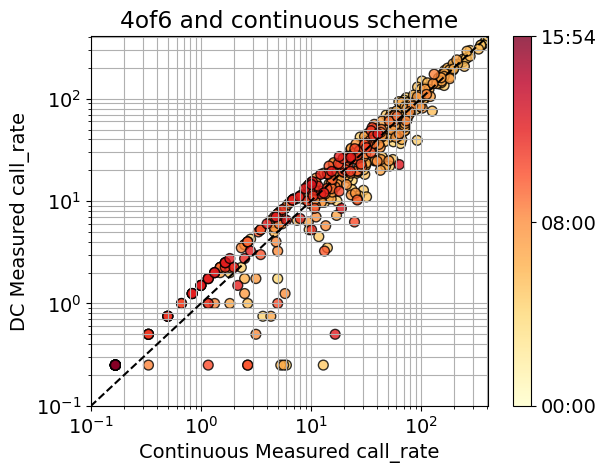

In [92]:
plot_indiv_dc_control_comp_over_cycle(plt_dcmetr, plt_cmetr, data_params)

In [93]:
dc_metr1 = pd.pivot_table(plt_dcmetr, index=(plt_dcmetr.index.time), 
                    columns=plt_dcmetr.index.date, 
                    values=plt_dcmetr.columns[0])
c_metr = pd.pivot_table(plt_cmetr, index=(plt_cmetr.index.time), 
                columns=plt_cmetr.index.date, 
                values=plt_cmetr.columns[0])
over_dc_test = dc_metr1[dc_metr1 > c_metr]
under_dc_test = dc_metr1[c_metr > dc_metr1]
over_c_test = c_metr[dc_metr1 > c_metr]
under_c_test = c_metr[c_metr > dc_metr1]
over_ratios = (over_dc_test / over_c_test)
under_ratios = (under_dc_test / under_c_test)
over_ratios

,2022-08-10,2022-08-11,2022-08-12,2022-08-13,2022-08-14,2022-08-15,2022-08-16
00:00:00,NaN,NaN,1.5,NaN,NaN,NaN,NaN
00:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:24:00,NaN,NaN,NaN,NaN,1.5,NaN,NaN
...,...,...,...,...,...,...,...
15:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15:42:00,1.5,NaN,NaN,1.5,NaN,NaN,NaN
15:48:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
most_ratio = stats.mode((over_ratios.values)[~over_ratios.isna()])
all_most = over_ratios[over_ratios==most_ratio[0]]
most_ratio

ModeResult(mode=1.5, count=87)

In [126]:
((dc_metr1)[dc_metr1==all_most*c_metr])[35:85]

,2022-08-10,2022-08-11,2022-08-12,2022-08-13,2022-08-14,2022-08-15,2022-08-16
03:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03:42:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03:48:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04:00:00,NaN,4.25,NaN,NaN,0.75,NaN,NaN
04:06:00,0.25,NaN,0.25,NaN,1.25,NaN,NaN
04:12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04:18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04:24:00,NaN,NaN,NaN,NaN,NaN,NaN,42.25


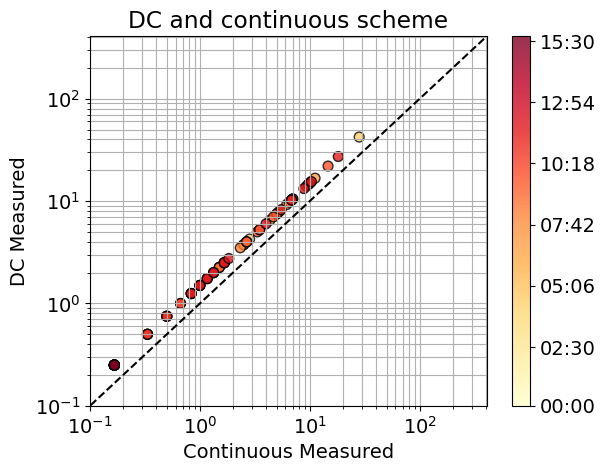

In [162]:
plt.title(f'DC and continuous scheme')
plt.plot([0, np.amax(c_metr)], [0, np.amax(c_metr)], linestyle='dashed', color='k')
colors = np.tile(np.arange(0, c_metr.shape[0]),(c_metr.shape[1],1)).T
labels = pd.to_datetime(c_metr.index, format='%H:%M:%S').strftime('%H:%M')
sc = plt.scatter(c_metr, dc_metr1[(dc_metr1/c_metr)==most_ratio[0]], c=colors, cmap='YlOrRd', edgecolors='k', s=50, alpha=0.8)
colo_inds = np.linspace(0, len(labels)-5, 7).astype('int')
cbar = plt.colorbar(sc, ticks=colors[colo_inds,0])
cbar.ax.set_yticklabels(labels[colo_inds])
plt.xlabel(f'Continuous Measured')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-1, np.amax(c_metr))
plt.ylim(1e-1, np.amax(c_metr))
plt.ylabel(f'DC Measured')
plt.grid(which='both')